#### Kaggle link: https://www.kaggle.com/datasets/wardabilal/spotify-global-music-dataset-20092025?select=track_data_final.csv

# Spotify Track Popularity Analysis

In this notebook, I explore a Spotify track dataset to understand what factors are associated with song popularity. I follow a structured data analysis workflow, starting from raw data inspection and cleaning, moving through exploratory analysis and visualization, and finally applying simple rule-based logic and database queries.

## Problem Context and Motivation

Music streaming platforms like Spotify collect detailed information about tracks, artists, and listener engagement. While popularity scores summarize how well a song performs, they do not explain what contributes to that success.

I carried out this analysis to better understand which characteristics of a track or artist are associated with higher popularity. By examining factors such as artist popularity, follower count, genre, explicit content, release year, and track duration, I aim to uncover patterns that help explain differences in track popularity.

## Research Questions
To guide my analysis, I focused on the following questions:

1. Is track popularity evenly distributed, or concentrated among a small number of songs?
2. How are artist popularity and follower count related to track popularity?
3. Do explicit tracks differ in popularity compared to non-explicit tracks?
4. Are certain genres, album types, or release periods associated with higher popularity?
5. Can simple rule-based logic be used to identify potential hit songs?

## Importing Libraries and Loading the Dataset

I began by importing the Python libraries required for data manipulation, numerical operations, and visualization. I then loaded the raw Spotify dataset into a Pandas DataFrame so that I could start inspecting its structure and contents.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [2]:
df = pd.read_csv("data/track_data_final.csv")
df_clean = df.copy()

df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8778 non-null   object 
 1   track_name          8776 non-null   object 
 2   track_number        8778 non-null   int64  
 3   track_popularity    8778 non-null   int64  
 4   track_duration_ms   8778 non-null   int64  
 5   explicit            8778 non-null   bool   
 6   artist_name         8774 non-null   object 
 7   artist_popularity   8774 non-null   float64
 8   artist_followers    8774 non-null   float64
 9   artist_genres       8774 non-null   object 
 10  album_id            8778 non-null   object 
 11  album_name          8776 non-null   object 
 12  album_release_date  8778 non-null   object 
 13  album_total_tracks  8778 non-null   int64  
 14  album_type          8778 non-null   object 
dtypes: bool(1), float64(2), int64(4), object(8)
memory usag

,track_id,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type
0,6pymOcrCnMuCWdgGVTvUgP,3,57,61,213173,False,Britney Spears,80.0,17755451.0,['pop'],325wcm5wMnlfjmKZ8PXIIn,The Singles Collection,2009-11-09,58,compilation
1,2lWc1iJlz2NVcStV5fbtPG,Clouds,1,67,158760,False,BUNT.,69.0,293734.0,['stutter house'],2ArRQNLxf9t0O0gvmG5Vsj,Clouds,2023-01-13,1,single
2,1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),11,63,225328,False,Taylor Swift,100.0,145396321.0,[],4hDok0OAJd57SGIT8xuWJH,Fearless (Taylor's Version),2021-04-09,26,album
3,7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,2,72,158463,True,Billie Eilish,90.0,118692183.0,[],0JGOiO34nwfUdDrD612dOp,Happier Than Ever,2021-07-30,16,album
4,0GLfodYacy3BJE7AI3A8en,Man Down,7,57,267013,False,Rihanna,90.0,68997177.0,[],5QG3tjE5L9F6O2vCAPph38,Loud,2010-01-01,13,album


## Data Cleaning and Wrangling Strategy

The raw dataset contains missing values, inconsistent data types, and genre information stored in nested formats. To ensure that my analysis is reliable, I applied a structured data cleaning process to transform the raw data into an analysis-ready dataset.

My cleaning approach focused on:
- Selecting only relevant variables
- Standardizing text fields and missing values
- Converting columns to appropriate data types
- Parsing and structuring genre information
- Applying sanity constraints to remove invalid records


### Selecting Relevant Columns

The original dataset includes several columns that are not directly relevant to my research questions. At this stage, I selected only the variables needed to analyze track popularity, artist characteristics, genre information, and release context.

In [3]:
keep_cols = [
    "track_id",
    "track_name",
    "track_popularity",
    "track_duration_ms",
    "explicit",
    "artist_name",
    "artist_popularity",
    "artist_followers",
    "artist_genres",
    "album_release_date",
    "album_type"
]

df_clean = df_clean[keep_cols]

### Cleaning Text Fields and Handling Missing Values

Some text-based columns contained extra whitespace or inconsistent representations of missing values. I cleaned these fields and normalized missing values so they could be handled consistently in later steps of the analysis.


In [4]:
text_cols = ["track_id", "track_name", "artist_name", "artist_genres", "album_type"]

for col in text_cols:
    df_clean[col] = df_clean[col].astype(str).str.strip()

df_clean.replace(
    {"": np.nan, "None": np.nan, "nan": np.nan, "N/A": np.nan},
    inplace=True
)

### Fixing Data Types and Creating Derived Features

To ensure accurate analysis and visualization, I converted numeric, boolean, and date columns to their appropriate data types. I also extracted the release year from the album release date, which allows me to analyze popularity trends over time.


In [5]:
df_clean["explicit"] = df_clean["explicit"].astype(bool)

num_cols = [
    "track_popularity",
    "track_duration_ms",
    "artist_popularity",
    "artist_followers"
]

for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

df_clean["album_release_date"] = pd.to_datetime(
    df_clean["album_release_date"], errors="coerce"
)

df_clean["release_year"] = (
    df_clean["album_release_date"]
    .dt.year
    .astype("Int64")
)

### Parsing and Structuring Genre Information

Genre information was stored as a string representation of lists, which is not directly usable for analysis. I parsed this field into a structured format and extracted a primary genre for each track. This step allows me to compare popularity patterns across genres in a consistent way.


In [6]:
def parse_genres(x):
    if pd.isna(x):
        return []
    x = str(x).strip()

    if x.startswith("[") and x.endswith("]"):
        try:
            genres = ast.literal_eval(x)
            if isinstance(genres, list):
                return [
                    g.strip()
                    for g in genres
                    if g and str(g).lower() not in {"nan", "none"}
                ]
        except Exception:
            return []

    return [g.strip() for g in x.split(",") if g.strip()]

df_clean["genres_list"] = df_clean["artist_genres"].apply(parse_genres)

df_clean["primary_genre"] = df_clean["genres_list"].apply(
    lambda g: g[0] if len(g) > 0 else "Unknown"
)

### Creating the Final Analysis Dataset

After cleaning and transforming the data, I created the final analysis dataset. This involved removing duplicate records, filtering out invalid values, and creating additional features such as track duration in minutes. The resulting dataset is used for all subsequent exploratory analysis.


In [7]:
df_clean = df_clean.dropna(
    subset=[
        "track_id",
        "track_name",
        "artist_name",
        "track_popularity",
        "track_duration_ms",
        "artist_popularity",
        "artist_followers",
    ]
)

df_clean = df_clean.drop_duplicates(subset="track_id")


df_clean = df_clean[
    df_clean["track_popularity"].between(0, 100) &
    df_clean["track_duration_ms"].between(30_000, 1_200_000)
]

df_clean = (
    df_clean
    .groupby(["track_name", "artist_name"], as_index=False)
    .agg({
        "track_popularity": "mean",
        "track_duration_ms": "mean",
        "explicit": "max",
        "artist_popularity": "mean",
        "artist_followers": "mean",
        "primary_genre": "first",
        "release_year": "first",
        "album_type": "first",
    })
)

df_final = df_clean.copy()

df_final["track_duration_min"] = (df_final["track_duration_ms"] / 60000).round(2)
df_final["primary_genre"] = df_final["primary_genre"].str.title()

df_final = df_final[df_final["release_year"].notna()].copy()
df_final.reset_index(drop=True, inplace=True)

print("Rows after cleaning:", df_final.shape[0])
print(
    "Duplicate tracks:",
    df_final.duplicated(subset=["track_name", "artist_name"]).sum()
)

df_final.info()
df_final.head(100)


Rows after cleaning: 7732
Duplicate tracks: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7732 entries, 0 to 7731
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_name          7732 non-null   object 
 1   artist_name         7732 non-null   object 
 2   track_popularity    7732 non-null   float64
 3   track_duration_ms   7732 non-null   float64
 4   explicit            7732 non-null   bool   
 5   artist_popularity   7732 non-null   float64
 6   artist_followers    7732 non-null   float64
 7   primary_genre       7732 non-null   object 
 8   release_year        7732 non-null   Int64  
 9   album_type          7732 non-null   object 
 10  track_duration_min  7732 non-null   float64
dtypes: Int64(1), bool(1), float64(5), object(4)
memory usage: 619.3+ KB


,track_name,artist_name,track_popularity,track_duration_ms,explicit,artist_popularity,artist_followers,primary_genre,release_year,album_type,track_duration_min
0,"""In The Hall Of The Mountain King"" from Peer G...",London Symphony Orchestra,52.0,150826.0,False,73.0,350662.0,Classical,2010,compilation,2.51
1,"""My Neighbor Totoro Symphony"" The Path of the ...",Joe Hisaishi,42.0,222000.0,False,68.0,1486975.0,Japanese Classical,2002,album,3.70
2,"""Slut!"" (Taylor's Version) (From The Vault)",Taylor Swift,73.0,180381.0,False,100.0,145396321.0,Unknown,2023,album,3.01
3,#GETITRIGHT,Miley Cyrus,44.0,264706.0,True,81.0,26564677.0,Unknown,2013,album,4.41
4,#thatPOWER,will.i.am,67.0,279506.0,False,73.0,4427758.0,Unknown,2013,album,4.66
...,...,...,...,...,...,...,...,...,...,...,...
95,6 Inch (feat. The Weeknd),Beyoncé,60.0,260440.0,True,84.0,41172203.0,Unknown,2016,album,4.34
96,6 Months Later,Megan Moroney,76.0,182868.0,False,73.0,1163610.0,Country,2025,single,3.05
97,6 foot with my boots on,Cwby,39.0,172612.0,False,37.0,11588.0,Unknown,2025,single,2.88
98,679 (feat. Remy Boyz),Fetty Wap,75.0,196693.0,True,70.0,5124577.0,Unknown,2015,single,3.28


Before moving on to exploratory analysis, I reviewed the structure and sample rows of the cleaned dataset. This confirmed that the data is consistent, complete, and ready for analysis.



## Exploratory Data Analysis

### Top artists

As a starting point, I wanted to see which artists stand out the most in this dataset.
Instead of looking at just one metric, I combine a few artist-level signals to get a
broader view of popularity.

For each artist, I look at their average popularity score, their follower count, and how
many tracks they have in the dataset. Follower counts are log-transformed to avoid extreme
values dominating the ranking, and all features are normalized so they are comparable.

These values are then combined into a simple popularity index, with more weight given to
artist popularity, followed by followers and track count.

In [8]:
artist_agg = (
    df_final
    .groupby("artist_name")
    .agg(
        avg_artist_popularity=("artist_popularity", "mean"),
        avg_artist_followers=("artist_followers", "mean"),
        track_count=("track_name", "count"),
    )
    .reset_index()
)

artist_agg["followers_log"] = np.log10(artist_agg["avg_artist_followers"] + 1)
features = ["avg_artist_popularity", "followers_log", "track_count"]

for col in features:
    min_val = artist_agg[col].min()
    max_val = artist_agg[col].max()
    artist_agg[col + "_norm"] = (artist_agg[col] - min_val) / (max_val - min_val)

artist_agg["artist_popularity_index"] = (
    0.5 * artist_agg["avg_artist_popularity_norm"] +
    0.3 * artist_agg["followers_log_norm"] +
    0.2 * artist_agg["track_count_norm"]
)

top_artists = artist_agg.sort_values(
    "artist_popularity_index", ascending=False
)

top_artists.head(10)


,artist_name,avg_artist_popularity,avg_artist_followers,track_count,followers_log,avg_artist_popularity_norm,followers_log_norm,track_count_norm,artist_popularity_index
2055,Taylor Swift,100.000000,1.454402e+08,245,8.162684,1.000000,1.000000,1.000000,1.000000
2146,The Weeknd,93.332583,1.129554e+08,111,8.052907,0.933326,0.986551,0.450820,0.852792
575,Drake,95.000000,1.030617e+08,77,8.013097,0.950000,0.981674,0.311475,0.831797
203,Bad Bunny,95.000000,1.025339e+08,54,8.010867,0.950000,0.981401,0.217213,0.812863
140,Ariana Grande,90.000000,1.073896e+08,79,8.030962,0.900000,0.983863,0.319672,0.809093
253,Billie Eilish,90.000000,1.187120e+08,56,8.074495,0.900000,0.989196,0.225410,0.791841
1189,Lana Del Rey,88.000000,5.179721e+07,81,7.714306,0.880000,0.945070,0.327869,0.789095
1056,Justin Bieber,91.000000,8.501944e+07,50,7.929518,0.910000,0.971435,0.200820,0.786594
633,Eminem,88.000000,1.045367e+08,61,8.019269,0.880000,0.982430,0.245902,0.783909
601,Ed Sheeran,88.000000,1.227846e+08,46,8.089144,0.880000,0.990991,0.184426,0.774182


The results are not too surprising. Artists like Taylor Swift, The Weeknd, and Drake show
up at the top because they are everywhere: they have huge audiences, strong visibility on
Spotify, and a lot of tracks in the dataset. Some artists score high mainly because they
are extremely popular, even if they do not release as much, while others benefit from
having a larger catalog.

### Descriptive Statistics

I started the exploratory analysis by examining summary statistics for key variables. This gave me a high-level understanding of distributions, central tendencies, and variability within the dataset.

In [9]:
df_final.describe(include="all")

,track_name,artist_name,track_popularity,track_duration_ms,explicit,artist_popularity,artist_followers,primary_genre,release_year,album_type,track_duration_min
count,7732,7732,7732.000000,7732.000000,7732,7732.000000,7.732000e+03,7732,7732.0,7732,7732.000000
unique,7281,2467,NaN,NaN,2,NaN,NaN,274,<NA>,3,NaN
top,Ghost,Taylor Swift,NaN,NaN,False,NaN,NaN,Unknown,<NA>,album,NaN
freq,7,245,NaN,NaN,5766,NaN,NaN,3875,<NA>,5214,NaN
mean,NaN,NaN,51.985985,208865.977921,NaN,68.838808,2.252232e+07,NaN,2015.433135,NaN,3.481101
std,NaN,NaN,22.529808,64139.110324,NaN,19.835935,3.662102e+07,NaN,9.69747,NaN,1.068997
min,NaN,NaN,0.000000,30706.000000,NaN,0.000000,0.000000e+00,NaN,1952.0,NaN,0.510000
25%,NaN,NaN,39.000000,171345.000000,NaN,58.000000,3.506470e+05,NaN,2012.0,NaN,2.860000
50%,NaN,NaN,56.000000,205346.000000,NaN,73.000000,5.315301e+06,NaN,2018.0,NaN,3.420000
75%,NaN,NaN,69.000000,239056.250000,NaN,83.000000,2.627580e+07,NaN,2022.0,NaN,3.980000


From these summary statistics, I observed that track popularity spans the full 0–100 range, with a median around the mid-to-high 50s. Artist popularity and follower counts show substantial variation, suggesting that some artists dominate attention while many others have relatively small audiences.

To better understand how popularity is distributed and how different categories are represented in the data, I examined value distributions and proportions for selected variables such as explicit content.

In [10]:
df_final["explicit"].value_counts(normalize=True)

explicit
False    0.745732
True     0.254268
Name: proportion, dtype: float64

### Aggregations & Transformations

While descriptive statistics provide insights into individual variables, aggregation allows me to examine patterns across groups. In this section, I aggregated popularity metrics by release year and genre to identify broader trends and structural differences in the data.

In [11]:
df_final["track_popularity"].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

0.10    20.0
0.25    39.0
0.50    56.0
0.75    69.0
0.90    77.0
Name: track_popularity, dtype: float64

The quantile values confirm that track popularity is unevenly distributed across the dataset. While the lower end of the distribution is relatively low (10% of tracks have a popularity of 9 or below), the median popularity is 58, indicating that at least half of the tracks achieve moderate popularity. The upper quantiles rise more gradually, with 75% of tracks below 71 and 90% below 79, showing that extremely high popularity is comparatively rare.

In [12]:
df_final.groupby("release_year")["track_popularity"].agg(
    ["mean", "median", "count"]
)

,mean,median,count
release_year,,,
1952,45.000000,45.0,1
1958,55.000000,55.0,1
1959,41.000000,41.0,2
1960,47.000000,47.0,1
1962,49.000000,49.5,4
...,...,...,...
2021,52.585004,61.0,399
2022,50.594368,56.0,438
2023,51.793471,55.0,485


The yearly aggregation highlights strong differences in how well each release year is represented in the data. Early years contain very few tracks, often only one or two, which makes their average and median popularity values unreliable. In contrast, recent years contain several hundred tracks per year. From around 2021 onward, average popularity stabilizes in the low-to-mid 50s, while medians remain close to the high-50 range.

Together, these results suggest that popularity is concentrated in a mid-to-high range rather than being evenly spread.

### Popularity Distribution

I began the visual analysis by examining the overall distribution of track popularity. This helps determine whether popularity is evenly spread across tracks or concentrated among a smaller subset.

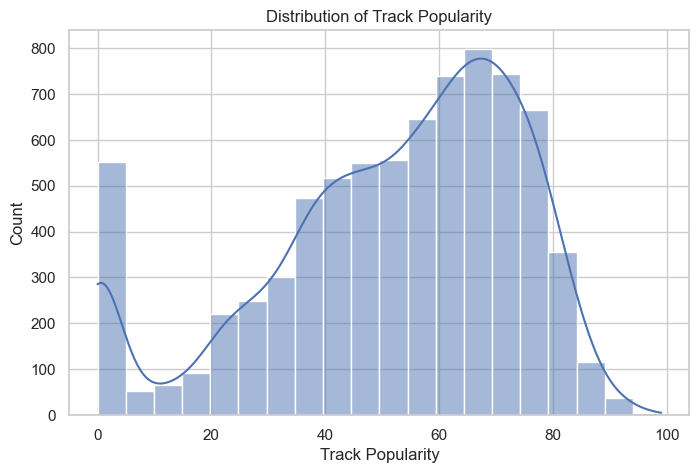

In [13]:
sns.histplot(df_final["track_popularity"], bins=20, kde=True)
plt.title("Distribution of Track Popularity")
plt.xlabel("Track Popularity")
plt.ylabel("Count")
plt.show()

The distribution of track popularity is clearly uneven. A very noticeable spike appears at popularity values close to 0, indicating that a substantial number of tracks receive little to no engagement. This suggests that many songs in the dataset are either very new, obscure, or have not accumulated enough listens to register a meaningful popularity score.

Beyond this initial spike, popularity increases steadily and peaks around the 60–75 range. This shows that a large portion of tracks in the dataset achieve moderate to high popularity rather than being evenly spread across the full scale. The long tail toward very high popularity values (above 80) indicates that truly top-performing tracks are relatively rare.

Overall, this distribution confirms that track popularity is highly skewed: most tracks either perform very poorly or cluster in the mid-to-high popularity range, while only a small fraction achieve extreme popularity.


### Correlation Matrix

To better understand how the key numerical variables relate to one another, I computed a correlation matrix including track popularity, artist popularity, artist follower count, and track duration. This helps identify which features tend to move together and which are largely independent.

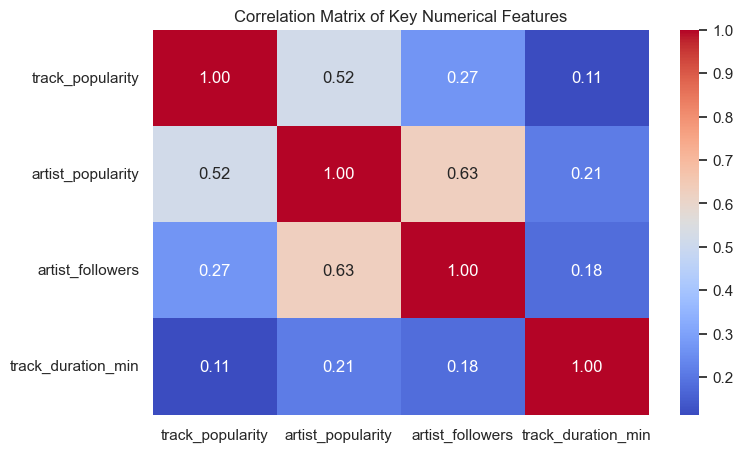

In [14]:
corr_cols = [
    "track_popularity",
    "artist_popularity",
    "artist_followers",
    "track_duration_min"
]

corr = df_final[corr_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Numerical Features")
plt.show()

When focusing on relationships involving track popularity, I can see that artist popularity shows the clearest positive association. Tracks released by more well-known artists generally tend to achieve higher popularity, although the relationship is not perfect and there is substantial variation.

Artist popularity is even more closely related to artist follower count, which is expected since both variables describe an artist’s overall reach and audience size. However, this stronger relationship exists between two artist-level measures and does not directly translate into how popular any individual track becomes.

### Popularity Over Time

Next, I analyzed how average track popularity changes across release years to identify long-term trends or structural shifts in the data.

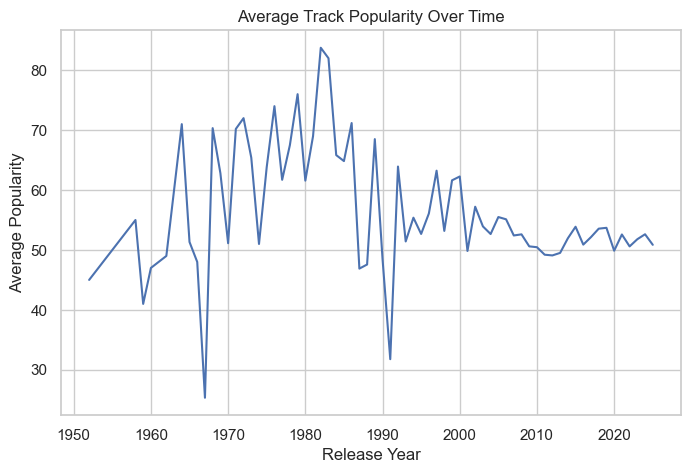

In [15]:
yearly_avg = (
    df_final.groupby("release_year")["track_popularity"]
    .mean()
    .reset_index()
)

sns.lineplot(data=yearly_avg, x="release_year", y="track_popularity")
plt.title("Average Track Popularity Over Time")
plt.xlabel("Release Year")
plt.ylabel("Average Popularity")
plt.show()

The line plot of average track popularity shows substantial volatility in earlier years, with sharp rises and drops from one year to the next. This suggests that early periods are represented by relatively few tracks in the dataset, making yearly averages highly sensitive to individual songs. As a result, fluctuations in these years are more likely driven by small sample sizes rather than true shifts in overall popularity.

From the late 1990s onward, the average popularity curve becomes noticeably smoother and more stable. This indicates that the dataset becomes denser in more recent years, with enough tracks per year for averages to be more reliable. In these later periods, average popularity generally stabilizes around the 50-60 range rather than showing a clear upward or downward trend.

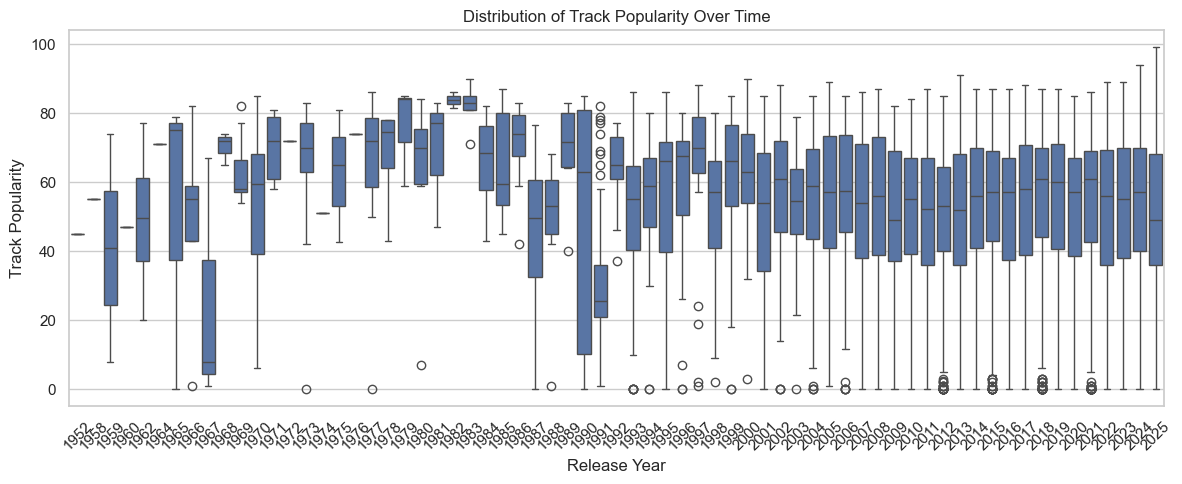

In [16]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df_final,
    x="release_year",
    y="track_popularity"
)
plt.xticks(rotation=45)
plt.title("Distribution of Track Popularity Over Time")
plt.xlabel("Release Year")
plt.ylabel("Track Popularity")
plt.tight_layout()
plt.show()

The boxplot provides additional context by showing the full distribution of popularity within each year. While median popularity remains relatively consistent over time, the spread within each year is wide, with both very low and very high-popularity tracks appearing in most periods. This suggests that changes in average popularity over time are less important than the persistent variability between individual tracks.

Taken together, these plots indicate that track popularity does not follow a strong long-term trend over time. Instead, popularity appears to be driven more by individual artists, tracks, and contextual factors than by the release period itself.

### Explicit Content Comparison

I compared the popularity distributions of explicit and non-explicit tracks to examine whether explicit content is associated with differences in popularity.

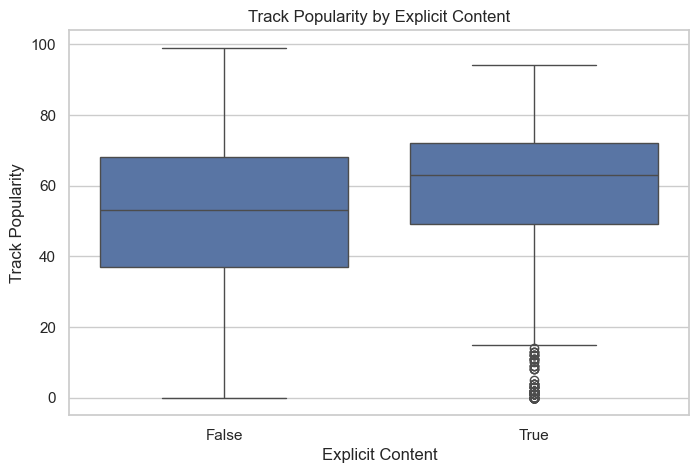

In [17]:
sns.boxplot(data=df_final, x="explicit", y="track_popularity")
plt.title("Track Popularity by Explicit Content")
plt.xlabel("Explicit Content")
plt.ylabel("Track Popularity")
plt.show()

From the boxplot, I observe that explicit tracks have a slightly higher median popularity compared to non-explicit tracks. This suggests that, in this dataset, explicit tracks tend to perform somewhat better on average.

However, the two distributions overlap substantially, and both explicit and non-explicit tracks span a wide range of popularity values, from very low to very high. This indicates that explicit content alone does not determine a track’s success. While explicit tracks may be more common among higher-popularity songs, many non-explicit tracks achieve similar popularity levels, and many explicit tracks still perform poorly.

### Average Track Popularity by Genre

To explore genre-level differences, I calculated the average track popularity for each genre and focused on the most prominent ones.


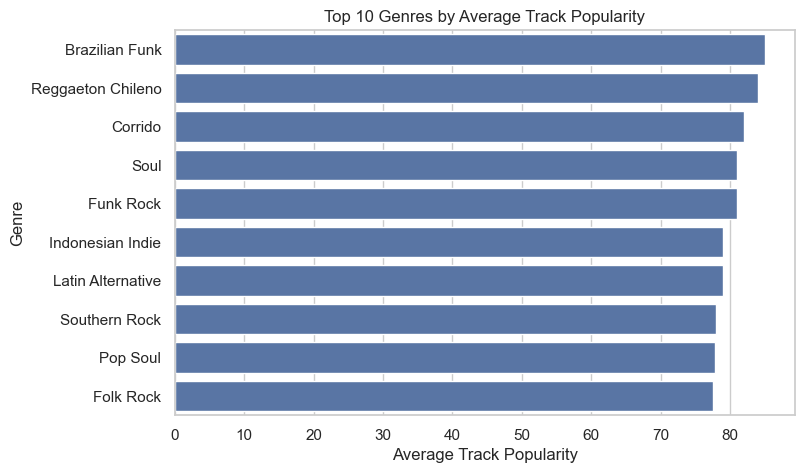

In [18]:
top_avg_genres = (
    df_final.groupby("primary_genre")["track_popularity"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

sns.barplot(x=top_avg_genres.values, y=top_avg_genres.index)
plt.title("Top 10 Genres by Average Track Popularity")
plt.xlabel("Average Track Popularity")
plt.ylabel("Genre")
plt.show()

I noticed that several relatively niche genres such as Brazilian Funk, Reggaeton Chileno, and Corrido appear at the top. These genres show very high average popularity values, often above 75.

However, this does not necessarily mean these genres consistently outperform more mainstream genres. Average popularity can be strongly influenced by small sample sizes. A genre with only a few highly successful tracks can rank very high even if it is not widely represented in the dataset.

This chart is therefore most useful for identifying genres that contain high-performing tracks, rather than genres that are broadly popular across many releases. To fully understand genre importance, this needs to be considered together with genre frequency.

### Genre Frequency

Finally, I examined how frequently different genres appear in the dataset to better understand its overall composition.


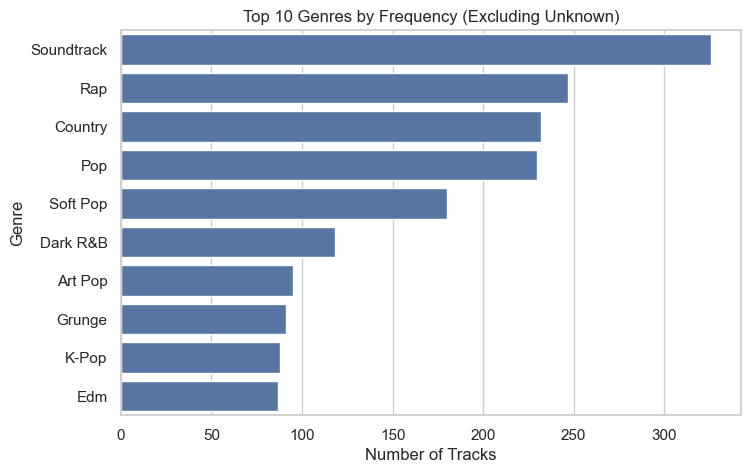

In [19]:
top_genre_counts = (
    df_final[df_final["primary_genre"] != "Unknown"]["primary_genre"]
    .value_counts()
    .head(10)
)

sns.barplot(x=top_genre_counts.values, y=top_genre_counts.index)
plt.title("Top 10 Genres by Frequency (Excluding Unknown)")
plt.xlabel("Number of Tracks")
plt.ylabel("Genre")
plt.show()


This chart reveals the composition of the dataset rather than performance. Genres such as Soundtrack, Pop, Rap, and Country appear most frequently, indicating that these genres are heavily represented in the data.

Comparing this chart with the “Top Genres by Average Popularity” highlights an important distinction: genres that dominate in frequency are not necessarily the ones with the highest average popularity. This reinforces why both frequency and average metrics need to be considered together.

High-frequency genres provide more stable and reliable averages, while low-frequency genres can appear artificially strong due to a small number of successful tracks.

### Artist Popularity vs Track Popularity

I examined the relationship between artist popularity and track popularity to assess whether more well-known artists tend to release more popular tracks.


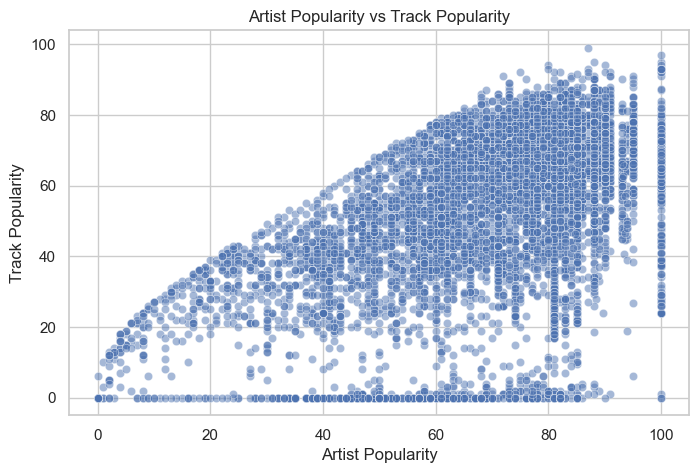

In [20]:
sns.scatterplot(
    data=df_final,
    x="artist_popularity",
    y="track_popularity",
    alpha=0.5
)
plt.title("Artist Popularity vs Track Popularity")
plt.xlabel("Artist Popularity")
plt.ylabel("Track Popularity")
plt.show()


I observe a clear upward trend: as artist popularity increases, track popularity generally tends to increase as well. Tracks by very low-popularity artists rarely achieve high popularity scores, while tracks by highly popular artists span a much wider range of outcomes.

That said, the relationship is far from perfect. Even among artists with very high popularity, there are many tracks with low or even zero popularity. This vertical spread shows that artist popularity helps increase the potential for a track to perform well, but it does not guarantee success.

Overall, this suggests that artist popularity is an important contributing factor to track popularity, but other elements such as promotion, timing, and listener reception clearly play a major role.

### Artist Followers vs Track Popularity

I then examined how artist follower counts relate to track popularity. Because follower counts span several orders of magnitude, I used a logarithmic scale.


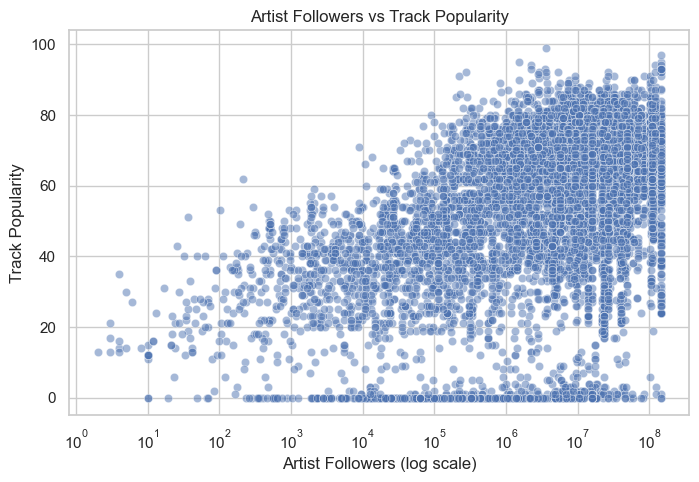

In [21]:
sns.scatterplot(
    data=df_final,
    x="artist_followers",
    y="track_popularity",
    alpha=0.5
)
plt.xscale("log")
plt.title("Artist Followers vs Track Popularity")
plt.xlabel("Artist Followers (log scale)")
plt.ylabel("Track Popularity")
plt.show()


Using a log scale reveals patterns that would otherwise be hidden due to the extremely wide range of follower counts. I can see that higher follower counts are generally associated with higher track popularity, but the relationship is much noisier than with artist popularity.

Many artists with millions of followers still have tracks with very low popularity, and some artists with relatively modest follower counts manage to achieve moderate popularity. This suggests that follower count reflects potential audience size, but it does not directly translate into engagement for every release.

Compared to artist popularity, follower count appears to be a weaker and less reliable indicator of individual track performance.

### Track Popularity by Album Type

I compared track popularity across different album types, such as albums, singles, and compilations.


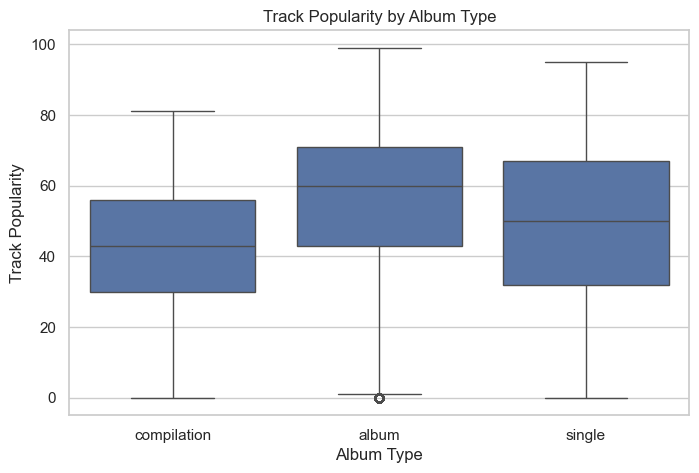

In [22]:
sns.boxplot(data=df_final, x="album_type", y="track_popularity")
plt.title("Track Popularity by Album Type")
plt.xlabel("Album Type")
plt.ylabel("Track Popularity")
plt.show()


From this plot, I observe that tracks released as albums tend to have a higher median popularity compared to singles and compilations. Singles also show a wide spread, with both very low and very high popularity values.

Compilation tracks generally have a lower median popularity, which may reflect the fact that compilations often include older, less actively promoted tracks.

However, the overlap between all three distributions is substantial. This indicates that album type alone does not determine popularity, but it does appear to be associated with differences in typical performance.

## Applying Logic and Rule-Based Classification

Beyond descriptive analysis, I applied simple rule-based logic to categorize tracks and identify potential hit songs.

### Popularity Buckets

I grouped tracks into Low, Medium, and High popularity categories based on their popularity score. This makes it easier to reason about trends using interpretable labels instead of raw numbers.

In [23]:
def popularity_bucket(popularity):
    if popularity <= 30:
        return "Low"
    elif popularity <= 60:
        return "Medium"
    else:
        return "High"

df_final["popularity_category"] = df_final["track_popularity"].apply(popularity_bucket)
df_final["popularity_category"].value_counts(normalize=True)


popularity_category
High      0.431712
Medium    0.402095
Low       0.166192
Name: proportion, dtype: float64

Based on these proportions, I observe that the largest share of tracks falls into the High popularity category (about 46%). Medium-popularity tracks make up a little over one-third of the dataset (around 36%), while Low-popularity tracks account for less than one-fifth (about 18%).

This distribution indicates that the dataset is skewed toward more popular tracks rather than being evenly balanced across popularity levels. As a result, the analysis reflects patterns among relatively successful songs more strongly than among low-engagement tracks.

### Simple Rule-Based Hit Identification

To assess whether simple rule-based logic can meaningfully identify hit songs, I first define a ground-truth notion of a “hit” based on relative popularity within the dataset. A track is considered a hit if its popularity score lies in the top 30% of all tracks. This percentile-based definition avoids arbitrary thresholds and adapts to the empirical distribution of popularity.

In [24]:
HIT_PERCENTILE = 0.70
popularity_cutoff = df_final["track_popularity"].quantile(HIT_PERCENTILE)

df_final["true_hit"] = (df_final["track_popularity"] >= popularity_cutoff).astype(int)

popularity_cutoff

np.float64(67.0)

Then, I implemented a simple rule-based classifier that flags a track as a potential hit based solely on artist-level characteristics. The rule assumes that artists with high popularity and very large follower bases are more likely to produce successful tracks, independent of the track’s observed popularity.

In [25]:
def rule_based_hit(row):
    if row["artist_popularity"] >= 75 and row["artist_followers"] >= 1_000_000:
        return 1
    return 0

df_final["predicted_hit"] = df_final.apply(rule_based_hit, axis=1)

The predicted labels are evaluated against the percentile-based hit definition using a confusion matrix and standard classification metrics, including accuracy, precision, and recall.

In [26]:
import pandas as pd

# Confusion matrix components
tp = ((df_final["predicted_hit"] == 1) & (df_final["true_hit"] == 1)).sum()
fp = ((df_final["predicted_hit"] == 1) & (df_final["true_hit"] == 0)).sum()
tn = ((df_final["predicted_hit"] == 0) & (df_final["true_hit"] == 0)).sum()
fn = ((df_final["predicted_hit"] == 0) & (df_final["true_hit"] == 1)).sum()

confusion_df = pd.DataFrame(
    {
        "Predicted Hit": [tp, fp],
        "Predicted Non-Hit": [fn, tn],
    },
    index=["Actual Hit", "Actual Non-Hit"],
)

confusion_df

,Predicted Hit,Predicted Non-Hit
Actual Hit,1652,753
Actual Non-Hit,1980,3347


In [27]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

accuracy, precision, recall

(np.float64(0.6465338851526126),
 np.float64(0.45484581497797355),
 np.float64(0.6869022869022869))

The results show that simple rule-based logic can capture a substantial share of hit songs, achieving a recall of approximately 70%. This indicates that artist popularity and audience size alone provide meaningful signals for identifying potentially successful tracks.

However, precision remains moderate, reflecting a high number of false positives. This suggests that while rule-based approaches are useful for early-stage screening, they are insufficient for precise hit prediction. Many highly popular artists still release tracks that do not achieve top-tier popularity.

Overall, this experiment demonstrates that rule-based logic can identify favorable conditions for success but cannot reliably predict hits on its own. More advanced models incorporating additional features or learning-based approaches would be required to improve precision.

### Normalized Similarity Comparison

I also attemted computing a similarity score. Since artist popularity, artist follower count, and track duration operate on different numerical scales, I did similarity analysis after applying a logarithmic transformation to follower count and manually normalizing all features to a 0–1 range. This ensures that no single feature dominates the distance calculation purely due to scale.

In [28]:
df_sim = df_final.copy()

df_sim["artist_followers_log"] = np.log10(df_sim["artist_followers"] + 1)

POPULARITY_THRESHOLD = df_sim["track_popularity"].quantile(0.99)

very_popular_tracks = df_sim[
    (df_sim["track_popularity"] >= POPULARITY_THRESHOLD) &
    (df_sim["artist_popularity"] >= 80)
].sort_values("track_popularity", ascending=False)

reference_track = very_popular_tracks.iloc[0]

reference_track[
    ["track_name", "artist_name", "track_popularity",
     "artist_popularity", "artist_followers", "track_duration_min"]
]

features = ["artist_popularity", "artist_followers_log", "track_duration_min"]

df_norm = df_sim.copy()

for col in features:
    min_val = df_norm[col].min()
    max_val = df_norm[col].max()
    df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)


In [29]:
from numpy.linalg import norm

reference_track_norm = df_norm.loc[reference_track.name]

def normalized_similarity_score(row, reference):
    return norm(row[features].values - reference[features].values)

df_final["similarity_to_popular_song"] = df_norm.apply(
    normalized_similarity_score,
    axis=1,
    reference=reference_track_norm
)


In [30]:
df_final[
    [
        "track_name",
        "artist_name",
        "artist_popularity",
        "track_popularity",
        "artist_followers",
        "track_duration_min",
        "similarity_to_popular_song"
    ]
].drop_duplicates(subset=["artist_name"]).sort_values("similarity_to_popular_song")

,track_name,artist_name,artist_popularity,track_popularity,artist_followers,track_duration_min,similarity_to_popular_song
2367,Golden,HUNTR/X,87.0,99.0,3551538.0,3.24,0.000000
791,Bloodline,Alex Warren,84.0,79.0,2896488.0,3.03,0.035752
2813,Hush,The Marías,83.0,70.0,3767285.0,3.03,0.043248
3648,Lose My Mind (feat. Doja Cat) [From F1® The Mo...,Don Toliver,85.0,83.0,7465428.0,3.48,0.047984
562,Bad Dreams,Teddy Swims,83.0,79.0,5670437.0,3.08,0.048692
...,...,...,...,...,...,...,...
6710,Voy a Brillar (Reggae),Serena Kaya,4.0,16.0,4.0,2.73,1.097396
5397,She´s in the Game (Brazilian Funk),Mc Slug,3.0,13.0,4.0,2.50,1.105747
2078,Fish-Woman (POP Version),Lucas Mazotti,3.0,13.0,3.0,2.63,1.113014
2884,I Just Want a Kiss (Brazilian Axé Version),Lia Morena,3.0,13.0,2.0,2.50,1.123556


When examining the ranked similarity results, the reference track Golden by HUNTR/X appears at the top with a similarity score of zero, as expected. The closest matches are dominated by songs from the same artist or from artists with very similar audience scale and market position. These tracks cluster closely in normalized feature space because they share comparable artist popularity, follower counts, and track duration.

As the similarity score increases, the results gradually shift toward tracks by different but still similarly positioned artists such as sombr and Alex Warren. None of the variables decrease smoothly across the ranking. Instead, artist popularity and follower count show an overall downward trend with noticeable fluctuations, reflecting meaningful differences even among similarly sized artists.

Track popularity also declines in an overall sense, but it is far more volatile, exhibiting large jumps and drops between neighboring ranks. This indicates that while less similar tracks tend to be less popular on average, individual song performance varies dramatically, even among artists with comparable reach.

Overall, this pattern suggests that after logarithmic transformation and normalization, the similarity metric is driven primarily by stable artist-level characteristics and basic track attributes such as duration, while track-level popularity contributes noisier, less predictable variation.

## SQL-Based Analysis

To demonstrate the use of SQL for data storage and querying, I organized the cleaned dataset into a simple relational structure using SQLite. I then performed a series of SQL queries involving joins, filtering, and aggregation to explore the data from a database perspective.

At this stage, I grouped the data at the artist level to create a separate artists table. Each artist appears only once, with their maximum popularity and follower count retained, along with a primary genre label. This structure allows artists and tracks to be linked cleanly using a unique artist identifier.

In [31]:
df_final.to_csv('data/final_cleaned_data.csv', index=False)

In [32]:
artists_df = (
    df_final
    .groupby("artist_name", as_index=False)
    .agg({
        "artist_popularity": "max",     
        "artist_followers": "max",      
        "primary_genre": "first"       
    })
)
                                          
artists_df["artist_id"] = artists_df.index + 1

artists_df = artists_df[
    [
        "artist_id",
        "artist_name",
        "artist_popularity",
        "artist_followers",
        "primary_genre"
    ]
]

artists_df.head()


,artist_id,artist_name,artist_popularity,artist_followers,primary_genre
0,1,$uicideboy$,83.0,8957416.0,Emo Rap
1,2,'Ery Noice,25.0,11720.0,Unknown
2,3,(((()))),51.0,49519.0,Unknown
3,4,*NSYNC,69.0,3088613.0,Unknown
4,5,-,28.0,714.0,Unknown


I then constructed a tracks table containing track-level attributes and a foreign key linking each track to its corresponding artist. Separating the data into artists and tracks reflects a simple relational database design and avoids repeating artist information for every track.

In [33]:
tracks_df = df_final.merge(
    artists_df[["artist_id", "artist_name"]],
    on="artist_name",
    how="left"
)

tracks_df = tracks_df[
    [
        "track_name",
        "track_popularity",
        "track_duration_min",
        "explicit",
        "release_year",
        "album_type",
        "artist_id"
    ]
]

tracks_df.head()

,track_name,track_popularity,track_duration_min,explicit,release_year,album_type,artist_id
0,"""In The Hall Of The Mountain King"" from Peer G...",52.0,2.51,False,2010,compilation,1262
1,"""My Neighbor Totoro Symphony"" The Path of the ...",42.0,3.70,False,2002,album,1003
2,"""Slut!"" (Taylor's Version) (From The Vault)",73.0,3.01,False,2023,album,2056
3,#GETITRIGHT,44.0,4.41,True,2013,album,1426
4,#thatPOWER,67.0,4.66,False,2013,album,2451


After preparing the artists and tracks tables, I stored both DataFrames in a SQLite database. This step persists the relational structure and allows the data to be queried using standard SQL.

In [34]:
import sqlite3

conn = sqlite3.connect("data/spotify_database.db")

artists_df.to_sql("artists", conn, if_exists="replace", index=False)
tracks_df.to_sql("tracks", conn, if_exists="replace", index=False)

7732

After loading both tables into SQLite, I inspected a small sample of rows from each table and verified that the join between tracks and artists works as expected. This confirms that the relational structure has been set up correctly.

In [35]:
pd.read_sql("SELECT * FROM artists LIMIT 5;", conn)

,artist_id,artist_name,artist_popularity,artist_followers,primary_genre
0,1,$uicideboy$,83.0,8957416.0,Emo Rap
1,2,'Ery Noice,25.0,11720.0,Unknown
2,3,(((()))),51.0,49519.0,Unknown
3,4,*NSYNC,69.0,3088613.0,Unknown
4,5,-,28.0,714.0,Unknown


In [36]:
pd.read_sql("SELECT * FROM tracks LIMIT 5;", conn)

,track_name,track_popularity,track_duration_min,explicit,release_year,album_type,artist_id
0,"""In The Hall Of The Mountain King"" from Peer G...",52.0,2.51,0,2010,compilation,1262
1,"""My Neighbor Totoro Symphony"" The Path of the ...",42.0,3.70,0,2002,album,1003
2,"""Slut!"" (Taylor's Version) (From The Vault)",73.0,3.01,0,2023,album,2056
3,#GETITRIGHT,44.0,4.41,1,2013,album,1426
4,#thatPOWER,67.0,4.66,0,2013,album,2451


In [37]:
pd.read_sql("""
SELECT t.track_name, a.artist_name, a.artist_id
FROM tracks t
JOIN artists a
  ON t.artist_id = a.artist_id
LIMIT 10;
""", conn)

,track_name,artist_name,artist_id
0,"""In The Hall Of The Mountain King"" from Peer G...",London Symphony Orchestra,1262
1,"""My Neighbor Totoro Symphony"" The Path of the ...",Joe Hisaishi,1003
2,"""Slut!"" (Taylor's Version) (From The Vault)",Taylor Swift,2056
3,#GETITRIGHT,Miley Cyrus,1426
4,#thatPOWER,will.i.am,2451
5,&burn (with Vince Staples),Billie Eilish,254
6,(Do The) Act Like You Never Met Me,TV Girl,2044
7,(Everything I Do) I Do It For You,Bryan Adams,319
8,(I Got That) Boom Boom (feat. Ying Yang Twins),Britney Spears,309
9,(I Just) Died In Your Arms,Cutting Crew,457


### Average track popularity by genre

I computed the average track popularity for each genre, excluding tracks with unknown genre labels.

In [38]:
query_1 = """
SELECT 
    a.primary_genre,
    AVG(t.track_popularity) AS avg_popularity,
    COUNT(*) AS num_tracks
FROM tracks t
JOIN artists a
    ON t.artist_id = a.artist_id
WHERE a.primary_genre != 'Unknown'
GROUP BY a.primary_genre
ORDER BY avg_popularity DESC
"""

df_q1 = pd.read_sql(query_1, conn)
df_q1


,primary_genre,avg_popularity,num_tracks
0,Brazilian Funk,85.000000,1
1,Reggaeton Chileno,84.000000,1
2,Corrido,82.000000,4
3,Soul,81.000000,1
4,Funk Rock,80.888889,9
...,...,...,...
268,Indonesian Hip Hop,0.000000,1
269,Dub,0.000000,1
270,Desi Pop,0.000000,1
271,Bolero,0.000000,1


### Explicit vs Non-Explicit Tracks

This query compares explicit and non-explicit tracks by calculating their average popularity and the number of tracks in each group.

In [39]:
query_2 = """
SELECT 
    t.explicit,
    AVG(t.track_popularity) AS avg_popularity,
    COUNT(*) AS num_tracks
FROM tracks t
GROUP BY t.explicit;
"""

df_q2 = pd.read_sql(query_2, conn)
df_q2


,explicit,avg_popularity,num_tracks
0,0,50.037542,5766
1,1,57.700492,1966


### Popularity Trends Over Time

To examine how track popularity varies across release years, I calculated the average popularity per year.

In [40]:
query_3 = """
SELECT 
    t.release_year,
    AVG(t.track_popularity) AS avg_popularity
FROM tracks t
WHERE t.release_year IS NOT NULL
GROUP BY t.release_year
ORDER BY t.release_year;
"""

df_q3 = pd.read_sql(query_3, conn)
df_q3


,release_year,avg_popularity
0,1952,45.000000
1,1958,55.000000
2,1959,41.000000
3,1960,47.000000
4,1962,49.000000
...,...,...
62,2021,52.585004
63,2022,50.594368
64,2023,51.793471
65,2024,52.620339


### Top Artists by Average Popularity

In this query, I identified artists with the highest average track popularity, restricting the results to artists with a minimum number of tracks.

In [41]:
query_4 = """
SELECT 
    a.artist_name,
    AVG(t.track_popularity) AS avg_popularity,
    COUNT(*) AS num_tracks
FROM tracks t
JOIN artists a
    ON t.artist_id = a.artist_id
GROUP BY a.artist_name
HAVING COUNT(*) >= 5
ORDER BY avg_popularity DESC
LIMIT 10;
"""

df_q4 = pd.read_sql(query_4, conn)
df_q4


,artist_name,avg_popularity,num_tracks
0,Red Hot Chili Peppers,80.888889,9
1,Arctic Monkeys,79.800000,10
2,Sabrina Carpenter,78.902778,30
3,Benson Boone,78.200000,5
4,XXXTENTACION,77.750000,8
5,sombr,77.500000,12
6,Gracie Abrams,76.375000,8
7,Billie Eilish,75.214286,56
8,Bad Bunny,74.379630,54
9,Tame Impala,74.375000,12


### Popularity by Album Type

Finally, I calculated average track popularity and track counts for each album type.

In [42]:
query_5 = """
SELECT 
    t.album_type,
    AVG(t.track_popularity) AS avg_popularity,
    COUNT(*) AS num_tracks
FROM tracks t
GROUP BY t.album_type
ORDER BY avg_popularity DESC;
"""

df_q5 = pd.read_sql(query_5, conn)
df_q5


,album_type,avg_popularity,num_tracks
0,album,55.060983,5214
1,single,46.841314,2057
2,compilation,40.162871,461


In [43]:
conn.close()

## Final Interpretation and Research Findings
This section brings together what the exploratory analysis shows about how popularity works on Spotify. The goal is not to predict hit songs, but to understand the patterns behind why some tracks perform better than others.

### 1. Is track popularity evenly distributed, or concentrated among a small number of songs?
Track popularity is clearly uneven. A large share of tracks sit at a popularity score of zero, meaning they attract little to no engagement at all. These tracks likely represent obscure releases, very new songs, or tracks that never managed to break through to a wider audience.

Once tracks move beyond zero, most of them cluster in a broad middle range rather than being evenly spread across the scale. This suggests that many songs achieve some level of visibility, but not enough to become standout successes. Only a small number of tracks reach very high popularity values near the top of the scale.

Overall, this shows that popularity on Spotify is highly concentrated. Many tracks fail to gain traction, a sizeable group achieves moderate success, and only a few become major hits. Reaching the very top appears to be the exception rather than the norm.

### 2. How are artist popularity and follower count related to track popularity?
Artist-level visibility has a clear connection to track popularity. As artist popularity and follower count increase, tracks generally tend to perform better, which is visible in the upward patterns in the scatter plots.

Artists with large audiences benefit from immediate exposure when releasing new music. Their tracks are more likely to appear in playlists, recommendations, and searches, giving them a strong starting advantage. This helps explain why tracks by popular artists often achieve higher popularity.

At the same time, the relationship is not guaranteed. Even very popular artists release tracks that perform poorly, and some less well-known artists manage to achieve high popularity. Artist visibility increases the chance of success, but it does not fully determine it.

### 3. Do explicit tracks differ in popularity compared to non-explicit tracks?
There is no strong or consistent difference between explicit and non-explicit tracks in terms of popularity. While explicit tracks sometimes show a slightly higher median, the overall distributions overlap heavily.

Both groups include tracks that perform very poorly as well as tracks that become highly popular. This suggests that explicit content by itself does not drive success on Spotify.

Instead, explicitness appears to be more of a stylistic or genre-related choice. Its impact on popularity seems minor compared to factors like artist visibility and competition.

### 4. Are certain genres, album types, or release periods associated with higher popularity?
The genre analysis highlights an important distinction between visibility and success. Some niche genres rank highly in average popularity, often because they include a small number of very successful tracks. Meanwhile, more mainstream genres dominate the dataset in terms of frequency but do not always achieve the highest averages.

This points to the role of competition. In highly saturated genres, it may be harder for individual tracks to stand out, while less crowded genres can appear strong on average due to a few standout releases. Album type shows some differences in typical popularity, but no format consistently guarantees success.

Over time, popularity patterns become more stable in later years. Earlier periods show more volatility, likely because fewer tracks are available. Overall, genre choice, album type, and timing matter, but they interact closely with competition and artist visibility.

### 5. Can simple rule-based logic be used to identify potential hit songs?
Simple rule-based logic can identify some potential hits, but only to a limited extent. When a hit is defined as a track in the top 30 percent of popularity, rules based on artist popularity and follower count manage to capture many genuinely popular tracks.

However, many tracks flagged as hits by the rule do not actually end up in the top tier. This leads to reasonable recall but relatively low precision. Artist-level visibility is clearly a useful signal, but it does not explain everything.

Overall, rule-based approaches work well as transparent and interpretable tools for exploration. They help illustrate general tendencies, but they cannot capture the full complexity of musical success, which depends on many factors beyond what is directly measured in the data.

## Overall Conclusion
Taken together, the analysis shows that Spotify popularity is shaped primarily by artist-level visibility and competitive dynamics. Most tracks struggle to gain attention, while a small number capture a disproportionate share of engagement.

Track-specific features such as duration or explicit content play a much smaller role. Popularity is less about individual song characteristics and more about who releases the track and how visible they already are.

While clear patterns emerge, predicting hit songs with a simple rule-based logic remains difficult. Success appears to depend on a mix of measurable factors and external influences that are not fully captured in the data.